# Semantic Brain Decoding

## Training Notebook

This notebook starts from the processed fMRI data and use a linear model or a classifier to estimate the image features.

We start importing all the needed packages

In [5]:
%pip install mat73
%pip install nibabel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:

import nibabel as nib
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from os.path import join as opj
import pandas as pd
import nltk
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('omw-1.4')
import tqdm
from torchsummary import summary
from PIL import Image

from sklearn.model_selection import train_test_split
import shutil
from scipy.stats import hypergeom
import seaborn as sns
from termcolor import colored
from sklearn.neighbors import NearestNeighbors
from torchvision.utils import make_grid
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
import nibabel.processing
import pickle
from scipy.io import loadmat
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

import ast

from god_decoding_utils import *
from networks import *



[nltk_data] Downloading package wordnet to /home/matteo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/matteo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 1. Data Loading

Processed data can be downloaded from https://figshare.com/articles/dataset/Generic_Object_Decoding/7387130 

For copyright reasons, authors didn't make the visual images used in our experiments publicly available. 
You can request us to share the stimulus images at https://forms.gle/ujvA34948Xg49jdn9.

Stimulus images used for higher visual area locazlier experiments in this study are available via https://forms.gle/c6HGatLrt7JtTGQk7.

To run the following cells:

1) put the downloaded fMRI files in the "data/fMRI/GOD" folder 
2) put the downloaded image stimuli in the "data/fMRI/imagenet/images" folder.
 


In [7]:
# Initialize sub and roi variables
# You can change sub to each number in [1-5]
sub = "3"
roi = "ROI_VC"

# Initialize kamitani_data_mat with the path to a file containing data for Subject 3
kamitani_data_mat = f"data/fMRI/GOD/Subject{sub}.h5"

# Initialize imagenet_dir with the path to a directory containing images
imagenet_dir = "data/fMRI/imagenet/images"

# Initialize test_img_csv and train_img_csv with the paths to two CSV files
test_img_csv = 'data/fMRI/GOD/imageID_test.csv'
train_img_csv = 'data/fMRI/GOD/imageID_training.csv'

# Create a data_handler object using the specified arguments
handler = data_handler(h5_file=kamitani_data_mat, test_img_csv=test_img_csv, train_img_csv=train_img_csv)

# Get data using the get_data method of the handler object
Y, Y_test, Y_test_avg = handler.get_data(normalize=1, roi=roi)

# Get labels using the get_labels method of the handler object
labels_train, labels = handler.get_labels()

# Get filenames using the get_filenames method of the handler object
filenames_train, filenames_test = handler.get_filenames()

# Convert filenames_train and filenames_test from arrays to Python lists
filenames_train = [i.item() for i in filenames_train]
filenames_test = [i.item() for i in filenames_test]

# Initialize an empty list called filenames_test_avg
filenames_test_avg = []

# Iterate 50 times
for i in range(50):
    # Append the first element from filenames_test whose label is equal to i to filenames_test_avg
    filenames_test_avg.append(np.array(filenames_test)[labels==i][0])


### Handle WordNet Mapping

ImageNet synsets (image names) are mapped to WordNet.

In [8]:
with open('class_to_wordnet.json',) as f:
    data = f.read()

class2wordnet = ast.literal_eval(data)
wordnet2class= {v["id"] : k for k,v in class2wordnet.items()}

In [9]:
# Initialize img_dir_path with the path to a directory containing training images
img_dir_path = "data/fMRI/imagenet/images/training"

# Initialize image_paths with a list of file paths to the training images
image_paths = [os.path.join(img_dir_path, i) for i in filenames_train]

# Initialize test_image_paths with a list of file paths to the test images
test_image_paths = [os.path.join(imagenet_dir,"test", i) for i in filenames_test_avg]

# Split the data into train and validation sets using the train_test_split function
fmri_train, fmri_val, image_train, image_val = train_test_split(Y, image_paths, test_size=0.1, random_state=42)


### Dataset and Dataloaders

A CustomDataset is implemented in the god_utils file that returns fmri data and the related image

In [10]:
# Initialize BS with the batch size
BS = 64

# Initialize normalize with a transformation that normalizes the data
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Initialize transform with a transformation that resizes and converts images to tensors
transform = torchvision.transforms.Compose([torchvision.transforms.Resize(224),
                                            torchvision.transforms.ToTensor(),
                                            normalize])

# Initialize train_dataset with a CustomDataset object using the fmri_train and image_train data and the transform
train_dataset = CustomDataset(fmri_train, image_train, transform)

# Initialize val_dataset with a CustomDataset object using the fmri_val and image_val data and the transform
val_dataset = CustomDataset(fmri_val, image_val, transform)

# Initialize test_dataset with a CustomDataset object using the Y_test_avg and test_image_paths data and the transform
test_dataset = CustomDataset(Y_test_avg, test_image_paths, transform)

# Initialize train_dataloader with a DataLoader object using the train_dataset and the specified batch size
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=False)

# Initialize val_dataloader with a DataLoader object using the val_dataset and the specified batch size
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BS, shuffle=False)

# Initialize test_dataloader with a DataLoader object using the test_dataset and the specified batch size
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=False)


## 2. CNN Model
Here is defined the pretrained model to extract features from image. By default in this code, the last layer before classification is used as the latent space that describe the semantic space representation of the image itself, because it is composed by high level features

In [11]:
# Load a pre-trained ResNet50 model from the torchvision library
model = torchvision.models.resnet50(pretrained=True)

# Get the list of child modules of the model
modules = list(model.children())

# Remove the last element of the list of child modules
modules = modules[:-1]

# Create a new Sequential model using the remaining child modules
model = nn.Sequential(*modules)


### Extract the latent representation for each image and store it
The following cell store in list fmri activity and latent representation for each image in the training, validation and test set

In [12]:
# Initialize empty lists to store the data
x_train = []
z_train = []
y_train = []

x_val = []
z_val = []
y_val = []

x_test = []
z_test = []
y_test = []

# Iterate over the train_dataloader, val_dataloader, and test_dataloader
# x are fMRI preprocessed data, y are the image stimuli

with torch.no_grad():
    for x, y in tqdm.tqdm(train_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_train.append(x)
        z_train.append(z.squeeze())
        y_train.append(y)

    for x, y in tqdm.tqdm(val_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_val.append(x)
        z_val.append(z.squeeze())
        y_val.append(y)
    for x, y in tqdm.tqdm(test_dataloader):
        # Use the model to compute the latent representation of y
        z = model(y)
        # Append the data to the respective lists
        x_test.append(x)
        z_test.append(z.squeeze())
        y_test.append(y)

# Concatenate the lists of data into numpy arrays
x_train = torch.cat(x_train, 0).numpy()
z_train = torch.cat(z_train, 0).numpy()
y_train = torch.cat(y_train, 0).numpy()

x_val = torch.cat(x_val, 0).numpy()
z_val = torch.cat(z_val, 0).numpy()
y_val = torch.cat(y_val, 0).numpy()

x_test = torch.cat(x_test, 0).numpy()
z_test = torch.cat(z_test, 0).numpy()
y_test = torch.cat(y_test, 0).numpy()


100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


## 3. Linear Model

This cell train a Ridge Regression between fMRI and latent space.

In [13]:
# boolean to determine if the model should be trained or not, otherwise load pretrained models
train=True

In [14]:
#retrieve the latent space dimension that is the last element of shape of z_train (n_stimulus,latent_dim) while the fmri dim is the last of x_train (n_stimuls,fmri_dim)
fmri_dim=x_train.shape[-1]
latent_dim=z_train.shape[-1]

#create a directory to save the models
os.makedirs("models",exist_ok=True)


In [15]:
# Initialize a Ridge model with specified alpha and maximum number of iterations
if train:
    ridge = Ridge(alpha=1000, max_iter=5000)

    # Fit the model to the training data
    ridge.fit(x_train, z_train)

else:
    #load a pretrained model
    ridge = pickle.load(open(f"models/ridge_sub{sub}.sav", 'rb'))


# Use the model to predict the latent representation of the test data
pred_test_latent = ridge.predict(x_test)

# Initialize epsilon with a small value
epsilon = 1e-10

# Standardize the predicted latent representation of the test data
std_norm_test_latent = (pred_test_latent - np.mean(pred_test_latent, axis=0)) / (epsilon + np.std(pred_test_latent, axis=0))

# Scale and shift the standardized predicted latent representation to match the scale and shift of the training data
pred_instance = std_norm_test_latent * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Use the model to predict the latent representation of the training and validation data
train_predicted = ridge.predict(x_train)
val_predicted = ridge.predict(x_val)

# Calculate the root mean squared error (RMSE) of the predictions
print("rmse", mean_squared_error(z_train, train_predicted))
print("rmse", mean_squared_error(z_val, val_predicted))
print("rmse", mean_squared_error(z_test, pred_instance))
print("rmse", mean_squared_error(z_test, pred_test_latent))

pickle.dump(ridge, open(f"models/ridge_sub{sub}.sav", 'wb'))


rmse 0.031131619920862955
rmse 0.20596414469737157
rmse 0.26675824246443525
rmse 0.16932684836048842


### 3B Eventually, train a Perceptron to map between fMRI and latent space. (OPTIONAL)

In our experiments, we found that results are worse using perceptron, but can be optimized.

In [16]:
# Initialize a BrainMLP model with specified latent dimension, hidden layer sizes, dropout rate, and activation function
brain_model = BrainMLP(latent_dim=latent_dim, hidden=[1024], dropout=0.3, activation="tanh")

# Print a summary of the model, including the input and output shapes and the number of parameters
summary(brain_model, (fmri_dim,), device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       4,755,456
              Tanh-2                 [-1, 1024]               0
           Dropout-3                 [-1, 1024]               0
            Linear-4                 [-1, 2048]       2,099,200
Total params: 6,854,656
Trainable params: 6,854,656
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 26.15
Estimated Total Size (MB): 26.21
----------------------------------------------------------------


/home/matteo/.local/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
# Convert the x_train, z_train, x_val, z_val, x_test, and z_test arrays to PyTorch tensors
train_brain_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(z_train))
val_brain_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(z_val))
test_brain_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_test), torch.Tensor(z_test))

# Create DataLoaders for the training, validation, and test sets
train_brain_dataloader = torch.utils.data.DataLoader(train_brain_dataset, batch_size=64, shuffle=True)
val_brain_dataloader = torch.utils.data.DataLoader(val_brain_dataset, batch_size=64, shuffle=True)
test_brain_dataloader = torch.utils.data.DataLoader(test_brain_dataset, batch_size=64, shuffle=True)


In [18]:
# Set the device to use for training
device = "cuda:0"

# Set the number of epochs to train for
EPOCHS = 200

# Set the step size and gamma for the learning rate scheduler
scheduler_step = 60
gamma = 0.5

# Move the brain model to the designated device
brain_model = brain_model.to(device)

# Create an Adam optimizer with a weight decay of 1e-5
optim = torch.optim.Adam(brain_model.parameters(), lr=3e-3, weight_decay=1e-5)

# Create a learning rate scheduler that reduces the learning rate by a factor of gamma every scheduler_step epochs
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=scheduler_step, gamma=gamma)

# Create a mean squared error loss function
criterion = nn.MSELoss()

# Uncomment the following line to use a cosine embedding loss instead
# criterion = nn.CosineEmbeddingLoss()
# model=model.to(device)

In [19]:
loss_history=[]
val_loss_history=[]

# frequency of validation
val_freq=1


# if train is set to True, train the model
if train:
    # create a progress bar
    pbar=tqdm.tqdm(range(EPOCHS))
    # iterate over the number of epochs
    for epoch in pbar:
        # call the train_brain_epoch function to train the model for one epoch
        loss=train_brain_epoch(brain_model,train_dataloader=train_brain_dataloader,criterion=criterion,optim=optim,device=device)

        # step the scheduler to adjust the learning rate
        scheduler.step()

        # append the loss to the loss history
        loss_history.append(loss)

        # if the current epoch is a multiple of val_freq, call the val_brain_epoch function to get the validation loss
        if epoch%val_freq==0:
            val_loss=val_brain_epoch(brain_model,val_dataloader=val_brain_dataloader,criterion=criterion,optim=optim,device=device)
            val_loss_history.append(val_loss)

        # update the progress bar description with the current epoch and loss information
        if epoch>val_freq:
            pbar.set_description(f"[INFO] epoch: {epoch} loss: {loss_history[-1]} val_loss: {val_loss_history[-1]}")
        else:
            pbar.set_description(f"[INFO] epoch: {epoch} loss: {loss_history[-1]}")


    #save final weights
    torch.save(brain_model.state_dict(),f"models/brain_model_weights_sub{sub}.pt")
            
else:
    #load pretrained models

    brain_model.load_state_dict(torch.load(f"models/brain_model_weights_sub{sub}.pt"))
    brain_model=brain_model.to(device)
    ridge = pickle.load(open(f"models/ridge_sub{sub}.sav", 'rb'))

[INFO] epoch: 199 loss: 0.04347758521051968 val_loss: 0.22093069553375244: 100%|██████████| 200/200 [00:16<00:00, 11.90it/s] 


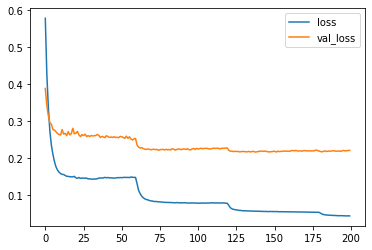

In [20]:
if train:
    plt.plot(loss_history,label="loss")
    plt.plot(val_loss_history,label="val_loss")
    plt.legend()

In [21]:
# Initialize variables for predictions on train, val, and test sets
train_predict = None
val_predict = None
test_predict = None

# Turn off gradient calculation
with torch.no_grad():
  # Make predictions on train set
  train_predict = brain_model(torch.Tensor(x_train).to(device)).cpu().numpy()
  # Make predictions on val set
  val_predict = brain_model(torch.Tensor(x_val).to(device)).cpu().numpy()
  # Make predictions on test set
  test_predict = brain_model(torch.Tensor(x_test).to(device)).cpu().numpy()

  # Standardize test predictions
  std_norm_test_latent = (test_predict - np.mean(test_predict, axis=0)) / np.std(test_predict, axis=0)
  # Adjust test predictions using mean and std of training set
  test_predicted_adjusted = std_norm_test_latent * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Calculate and print root mean squared error for train, val, and test sets
print("rmse", mean_squared_error(z_train, train_predict))
print("rmse", mean_squared_error(z_val, val_predict))
print("rmse", mean_squared_error(z_test, test_predicted_adjusted))
print("rmse", mean_squared_error(z_test, test_predict))


rmse 0.019187706
rmse 0.22068253
rmse 0.26377356
rmse 0.1762782


## 4. Classification
Following cells use nearest neighbors in the latent space to provide candidate labels for classification.
Image features and relative labels can be extracted using the original ImageNet dataset but since this is time consuming a subset of 500K image features with labels can be downloaded from https://drive.google.com/drive/folders/1wHN1QZkwjan1jp6wDrezWNcCm8kVqOeJ?usp=share_link  


In [22]:
#transform to restore original image means and stds
unnorm = torchvision.transforms.Compose([ torchvision.transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), torchvision.transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1.,1.,1.] )])


In [23]:
#where image features are saved
features_path="data/fMRI/imagenet/features/feature_imagenet_500_resnet50.pt"
labels_path="data/fMRI/imagenet/features/labels_imagenet_500_resnet50.pt"

#load image features
features=torch.load(features_path)
labels=torch.load(labels_path)

In [24]:
# Load labels for classifying the images
with open('classes.txt', 'rb') as handle:
    data_dict = handle.read()
idx2name = pickle.loads(data_dict)

# Load a pre-trained ResNet50 model and use the last fully-connected layer as the classifier head (should be the head of the CNN used before!)
clf = torchvision.models.resnet50(pretrained=True)
modules = list(clf.children())[-1:]
clf = nn.Sequential(*modules)

# Load the Nearest Neighbors model and fit it to the features of the images
nbrs = NearestNeighbors(n_neighbors=5).fit(features.numpy())

### 4.1 Classification with classifier and nearest neighbors
These are two methods to provide classes. We found the best one was the nearest neighbors.


In [27]:
# Initialize lists to store the predictions made by each model on the test data
z_test_brain = []
z_test_ridge = []
z_test_model = []
images_test = []

# Disable gradient calculation
with torch.no_grad():
    # Iterate over the test data using a progress bar
    for x, y in tqdm.tqdm(test_dataloader):
        # Make predictions using the brain_model
        z_b = brain_model(x.float().to(device)).cpu()
        # Make predictions using the model
        z_m = model(y).cpu().squeeze()
        # Make predictions using the ridge model
        z_r = torch.Tensor(ridge.predict(x.numpy()))
        
        # Append the predictions to the appropriate lists
        z_test_brain.append(z_b)
        z_test_model.append(z_m)
        z_test_ridge.append(z_r)
        images_test.append(y)

# Concatenate the lists of predictions into tensors
z_test_brain = torch.cat(z_test_brain, 0)
z_test_model = torch.cat(z_test_model, 0)
z_test_ridge = torch.cat(z_test_ridge, 0)
# Concatenate the list of input data into a tensor
images_test = torch.cat(images_test, 0)


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [28]:
# Standardize the test brain predictions using the mean and standard deviation of the training data
z_test_brain_std_norm = (z_test_brain - z_test_brain.mean(dim=0)) / z_test_brain.std(dim=0)
# Adjust the standardized test brain predictions using the mean and standard deviation of the training data
z_test_brain_adj = z_test_brain_std_norm * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Standardize the test ridge predictions using the mean and standard deviation of the training data
z_test_ridge_std_norm = (z_test_ridge - z_test_ridge.mean(dim=0)) / z_test_ridge.std(dim=0)
# Adjust the standardized test ridge predictions using the mean and standard deviation of the training data
z_test_ridge_adj = z_test_ridge_std_norm * np.std(z_train, axis=0) + np.mean(z_train, axis=0)

# Use the clf model to classify the test brain, model, and ridge predictions
out_test_brain = clf(z_test_brain_adj)
out_test_model = clf(z_test_model)
out_test_ridge = clf(z_test_ridge_adj)


### Examples of classifications

Choose a random integer i or change it in [0,49] to generate Nearest Neighbors candidates for a specific image and show the result.

[MODEL] is the CNN model output with image as input, to have an upper bound in classification accuracy. <br>
[BRAIN] is the multilayer perceptron model to estimate features from fMRI activity <br>
[RIDGE] is the ridge model to estimate image features from fMRI activity<br> 

*clf* is the head of the CNN used for classification, where *nn* are the labels of the 5 nearest point in the latent space.

clf brain: stretcher
clf ridge: Afghan hound, Afghan

NN [MODEL] closest: swing
NN [BRAIN] closest: shower cap
NN [RIDGE] closest: jean, blue jean, denim

NN [MODEL] other guess: swing rocking chair, rocker crutch swing crutch
NN [BRAIN] other guess: shower cap shower cap jean, blue jean, denim flat-coated retriever giant schnauzer
NN [RIDGE] other guess: jean, blue jean, denim miniskirt, mini shower cap shower cap giant schnauzer


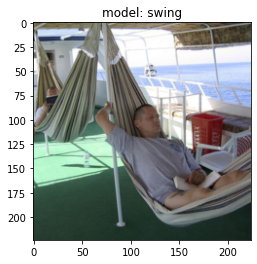

In [30]:
# Select a random test sample
i = np.random.randint(0, 50)

# Use the nearest neighbors model to find the nearest neighbors of the test brain, model, and ridge predictions
nn_brain = nbrs.kneighbors(z_test_brain_adj[i].numpy().reshape(1, -1))
nn_model = nbrs.kneighbors(z_test_model[i].numpy().reshape(1, -1))
nn_ridge = nbrs.kneighbors(z_test_ridge_adj[i].numpy().reshape(1, -1))

# Plot the selected test sample
plt.imshow(unnorm(images_test[i]).permute(1, 2, 0))
plt.title(f"model: {idx2name[out_test_model[i].argmax().item()]}")

# Print the classifications made by the clf model for the test brain, model, and ridge predictions
print(f"clf brain: {idx2name[out_test_brain[i].argmax().item()]}")
print(f"clf ridge: {idx2name[out_test_ridge[i].argmax().item()]}")
print()

# Get the classifications of the nearest neighbors for the test brain, model, and ridge predictions
nn_model_guess = [idx2name[i.item()] for i in labels[nn_model[1][0]]]
nn_brain_guess = [idx2name[i.item()] for i in labels[nn_brain[1][0]]]
nn_ridge_guess = [idx2name[i.item()] for i in labels[nn_ridge[1][0]]]

# Print the nearest neighbor classification for the test brain, model, and ridge predictions
print(f"NN [MODEL] closest: {nn_model_guess[0]}")
print(f"NN [BRAIN] closest: {nn_brain_guess[0]}")
print(f"NN [RIDGE] closest: {nn_ridge_guess[0]}")
print()

# Print the other nearest neighbor classifications for the test brain, model, and ridge predictions
print(f"NN [MODEL] other guess: {' '.join(nn_model_guess)}")
print(f"NN [BRAIN] other guess: {' '.join(nn_brain_guess)}")
print(f"NN [RIDGE] other guess: {' '.join(nn_ridge_guess)}")
